In [24]:
# Install required packages
%pip install xarray netCDF4 matplotlib cartopy

Note: you may need to restart the kernel to use updated packages.


In [25]:
# Import required libraries
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define CESM files for different resolutions
cesm_files = {
    'coarse': {
        'file': 'fv_1.9x2.5_nc3000_Nsw084_Nrs016_Co120_Fi001_ZR_GRNL_031819.nc',
        'label': 'Coarse (~1.9°×2.5°)',
        'short': 'f19'
    },
    'medium': {
        'file': 'fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_160505.nc',
        'label': 'Medium (~0.9°×1.25°)',
        'short': 'f09'
    },
    'fine': {
        'file': 'fv_0.47x0.63_nc3000_Co030_Fi001_PF_nullRR_Nsw021_20171023.nc',
        'label': 'Fine (~0.47°×0.63°)',
        'short': 'f05'
    }
}

# United States region: focused coverage
# Latitude: 24°N to 50°N (covers continental US)
# Longitude: 235°E to 300°E (converts to -125°W to -60°W, covers US from Pacific to Atlantic)
us_lat_range = (24, 50)
us_lon_range = (235, 300)

# Load all three CESM resolutions
cesm_datasets = {}
for resolution, info in cesm_files.items():
    print(f"\nLoading {info['label']} resolution...")
    ds = xr.open_dataset(info['file'])
    us_subset = ds.sel(lat=slice(us_lat_range[0], us_lat_range[1]), 
                       lon=slice(us_lon_range[0], us_lon_range[1]))
    ds = us_subset[['PHIS']]
    
    # Calculate resolution
    lat_spacing = np.diff(ds.lat.values).mean()
    lon_spacing = np.diff(ds.lon.values).mean()
    resolution_str = f"~{lat_spacing:.2f}°×{lon_spacing:.2f}°"
    
    cesm_datasets[resolution] = {
        'ds': ds,
        'label': info['label'],
        'short': info['short'],
        'resolution': resolution_str,
        'lat_spacing': lat_spacing,
        'lon_spacing': lon_spacing
    }
    
    print(f"  Shape: {ds.PHIS.shape}")
    print(f"  Resolution: {resolution_str}")
    print(f"  Lat range: {float(ds.lat.min()):.2f}° to {float(ds.lat.max()):.2f}°")
    print(f"  Lon range: {float(ds.lon.min()):.2f}° to {float(ds.lon.max()):.2f}°")

print(f"\n✓ Loaded {len(cesm_datasets)} CESM resolutions")


Loading Coarse (~1.9°×2.5°) resolution...
  Shape: (13, 27)
  Resolution: ~1.89°×2.50°
  Lat range: 25.58° to 48.32°
  Lon range: 235.00° to 300.00°

Loading Medium (~0.9°×1.25°) resolution...
  Shape: (28, 53)
  Resolution: ~0.94°×1.25°
  Lat range: 24.03° to 49.48°
  Lon range: 235.00° to 300.00°

Loading Fine (~0.47°×0.63°) resolution...
  Shape: (55, 105)
  Resolution: ~0.47°×0.62°
  Lat range: 24.20° to 49.58°
  Lon range: 235.00° to 300.00°

✓ Loaded 3 CESM resolutions


In [26]:
# Convert geopotential (PHIS) to elevation in meters for all resolutions
g0 = 9.8065  # Standard gravity in m/s²

for resolution, data in cesm_datasets.items():
    data['ds']["elevation"] = data['ds'].PHIS / g0
    data['ds'] = data['ds'].load()
    
    elev_min = float(data['ds'].elevation.min().values)
    elev_max = float(data['ds'].elevation.max().values)
    print(f"{data['label']}: Elevation range {elev_min:.1f} to {elev_max:.1f} m")

print("\n✓ All elevations converted from geopotential to meters")
print("Each grid cell represents how CESM stores elevation: discrete values at grid cell centers")

Coarse (~1.9°×2.5°): Elevation range 0.0 to 2294.5 m
Medium (~0.9°×1.25°): Elevation range 0.0 to 2708.3 m
Fine (~0.47°×0.63°): Elevation range 0.0 to 3061.9 m

✓ All elevations converted from geopotential to meters
Each grid cell represents how CESM stores elevation: discrete values at grid cell centers


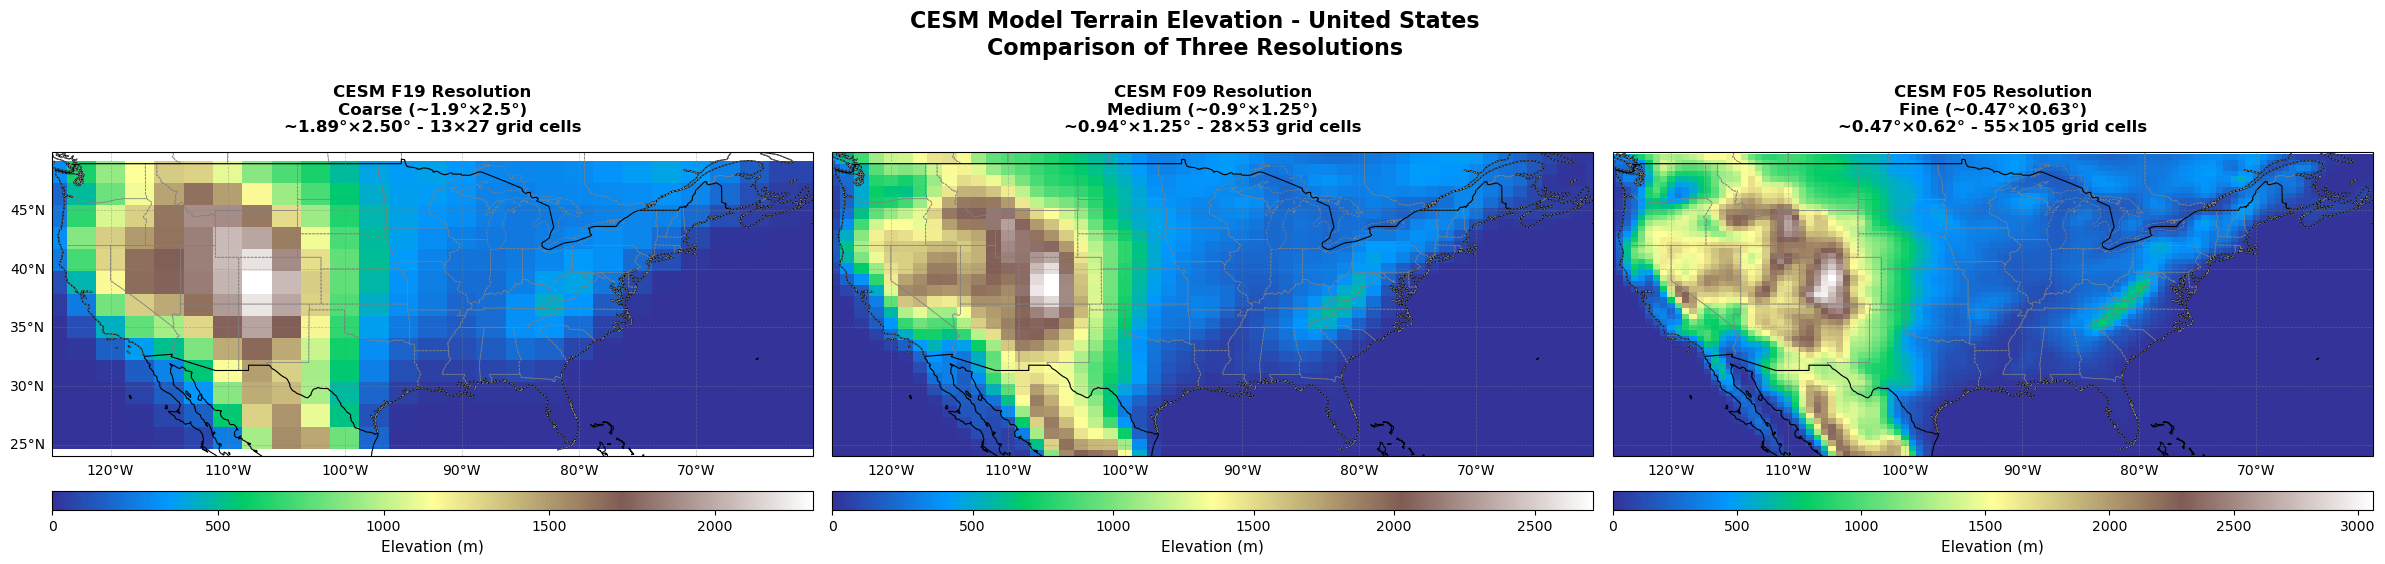

In [27]:
# Create comparison plot showing all three CESM resolutions side by side
fig, axes = plt.subplots(1, 3, figsize=(24, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Common settings
plot_extent = [-125, -60, 24, 50]
cmap = 'terrain'

# Plot each resolution
for idx, (resolution, data) in enumerate(cesm_datasets.items()):
    ax = axes[idx]
    ds = data['ds']
    
    # Get coordinate values
    lon_values_raw = ds.lon.values
    lat_values = ds.lat.values
    elevation_values = ds.elevation.values
    
    # Convert longitude from 0-360 to -180-180
    lon_values = np.where(lon_values_raw > 180, lon_values_raw - 360, lon_values_raw)
    
    # Create edge coordinates for pcolormesh
    lon_spacing = data['lon_spacing']
    lat_spacing = data['lat_spacing']
    
    lon_edges_raw = np.concatenate([[lon_values_raw[0] - lon_spacing/2], 
                                     lon_values_raw + lon_spacing/2])
    lat_edges = np.concatenate([[lat_values[0] - lat_spacing/2], 
                                lat_values + lat_spacing/2])
    
    lon_edges = np.where(lon_edges_raw > 180, lon_edges_raw - 360, lon_edges_raw)
    
    # Create plot
    im = ax.pcolormesh(lon_edges, lat_edges, elevation_values, 
                       cmap=cmap, transform=ccrs.PlateCarree(), shading='auto')
    
    # Add coastlines and boundaries
    ax.coastlines(resolution='50m', linewidth=0.8, color='black')
    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray', linestyle='--')
    ax.add_feature(cfeature.BORDERS, linewidth=0.8, edgecolor='black')
    ax.set_extent(plot_extent, crs=ccrs.PlateCarree())
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05, aspect=40)
    cbar.set_label('Elevation (m)', fontsize=11)
    
    # Add title with resolution info
    ax.set_title(f'CESM {data["short"].upper()} Resolution\n{data["label"]}\n{data["resolution"]} - {elevation_values.shape[0]}×{elevation_values.shape[1]} grid cells', 
                fontsize=12, fontweight='bold', pad=15)
    
    # Add gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    if idx > 0:  # Only show labels on leftmost plot
        gl.left_labels = False

# Add main title with reduced spacing - positioned closer to plots
plt.suptitle('CESM Model Terrain Elevation - United States\nComparison of Three Resolutions', 
             fontsize=16, fontweight='bold', y=0.75)

# Adjust layout to minimize whitespace - increase top margin to use more vertical space
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

In [28]:
# Save high-resolution comparison plot
output_file = 'CESM_terrain_US_multiresolution.png'
fig.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ High-resolution comparison plot saved: {output_file}")

# Also save individual plots for each resolution
for resolution, data in cesm_datasets.items():
    fig_single, ax_single = plt.subplots(figsize=(14, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    
    ds = data['ds']
    lon_values_raw = ds.lon.values
    lat_values = ds.lat.values
    elevation_values = ds.elevation.values
    
    lon_values = np.where(lon_values_raw > 180, lon_values_raw - 360, lon_values_raw)
    
    lon_spacing = data['lon_spacing']
    lat_spacing = data['lat_spacing']
    
    lon_edges_raw = np.concatenate([[lon_values_raw[0] - lon_spacing/2], 
                                     lon_values_raw + lon_spacing/2])
    lat_edges = np.concatenate([[lat_values[0] - lat_spacing/2], 
                                lat_values + lat_spacing/2])
    
    lon_edges = np.where(lon_edges_raw > 180, lon_edges_raw - 360, lon_edges_raw)
    
    im = ax_single.pcolormesh(lon_edges, lat_edges, elevation_values, 
                               cmap=cmap, transform=ccrs.PlateCarree(), shading='auto')
    ax_single.coastlines(resolution='50m', linewidth=0.8, color='black')
    ax_single.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray', linestyle='--')
    ax_single.add_feature(cfeature.BORDERS, linewidth=0.8, edgecolor='black')
    ax_single.set_extent(plot_extent, crs=ccrs.PlateCarree())
    
    cbar = plt.colorbar(im, ax=ax_single, orientation='horizontal', pad=0.05, aspect=40)
    cbar.set_label('Elevation (m)', fontsize=12, fontweight='bold')
    
    ax_single.set_title(f'CESM Model Terrain Elevation - United States\n{data["label"]} ({data["resolution"]} Resolution)', 
                        fontsize=14, fontweight='bold', pad=20)
    
    gl = ax_single.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                             linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    plt.tight_layout()
    
    output_single = f'CESM_terrain_US_{data["short"]}.png'
    fig_single.savefig(output_single, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✓ Saved: {output_single}")
    plt.close(fig_single)

print("\n✓ All plots saved successfully!")
print("\nThis comparison shows how CESM resolution affects terrain representation:")
print("- Coarse resolution captures large-scale features")
print("- Fine resolution captures more local topographic detail")
print("- Each grid cell represents a discrete elevation value used by the model")

✓ High-resolution comparison plot saved: CESM_terrain_US_multiresolution.png
✓ Saved: CESM_terrain_US_f19.png
✓ Saved: CESM_terrain_US_f09.png
✓ Saved: CESM_terrain_US_f05.png

✓ All plots saved successfully!

This comparison shows how CESM resolution affects terrain representation:
- Coarse resolution captures large-scale features
- Fine resolution captures more local topographic detail
- Each grid cell represents a discrete elevation value used by the model
